In [1]:
!pip install -q tweet-preprocessor ekphrasis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.8/83.8 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.2/53.2 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 5.9 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
import json
from collections import Counter
import re
import string
import unicodedata

import nltk
from nltk import word_tokenize, sent_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
import preprocessor as p
from gensim.parsing.preprocessing import remove_stopwords

import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')


%matplotlib inline

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
data_dir = "/content/"
filename = "labeled_data.csv"

In [4]:
data = pd.read_csv(os.path.join(data_dir, filename))
data.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [5]:
data.shape

(24783, 7)

In [6]:
features = ["tweet"]
labels = ["class"]
df = data[features + labels]
df["class"] = df["class"].map({0: "hate", 1: "hate", 2: "normal"})

In [7]:
def preprocess_tweet(row):
    text = row['tweet']
    text = p.clean(text)
    return text

df['tweet'] = df.apply(preprocess_tweet, axis=1)


In [8]:
df

,tweet,class
0,!!! RT : As a woman you shouldn't complain abo...,normal
1,!!!!! RT : boy dats cold...tyga dwn bad for cu...,hate
2,!!!!!!! RT Dawg!!!! RT : You ever fuck a bitch...,hate
3,!!!!!!!!! RT : she look like a tranny,hate
4,!!!!!!!!!!!!! RT : The shit you hear about me ...,hate
...,...,...
24778,you's a muthaf***in lie &;: right! His TL is t...,hate
24779,"you've gone and broke the wrong heart baby, an...",normal
24780,young buck wanna eat!!.. dat nigguh like I ain...,hate
24781,youu got wild bitches tellin you lies,hate


In [9]:
def stopword_removal(row):
    text = row['tweet']
    text = remove_stopwords(text)
    return text

df['tweet'] = df.apply(stopword_removal, axis=1)


In [10]:
df['tweet'] = df['tweet'].str.lower().str.replace('[^\w\s]',' ').str.replace('\s\s+', ' ')


In [11]:
def lemmatizing(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        lemma_word = lemmatizer.lemmatize(tokens[i])
        tokens[i] = lemma_word
    return " ".join(tokens)
df['tweet'] = df['tweet'].apply(lambda x: lemmatizing(x))


In [12]:
le = LabelEncoder()
df["class"] = le.fit_transform(df["class"])

In [13]:
df

,tweet,class
0,rt a woman shouldn t complain cleaning house a...,1
1,rt boy dat cold tyga dwn bad cuffin dat hoe st...,0
2,rt dawg rt you fuck bitch start cry you confus...,0
3,rt look like tranny,0
4,rt the shit hear true faker bitch told ya,0
...,...,...
24778,you s muthaf in lie right his tl trash now min...,0
24779,you ve gone broke wrong heart baby drove redne...,1
24780,young buck wan na eat dat nigguh like i aint f...,0
24781,youu got wild bitch tellin lie,0


In [14]:
df.isnull().any()

tweet    False
class    False
dtype: bool

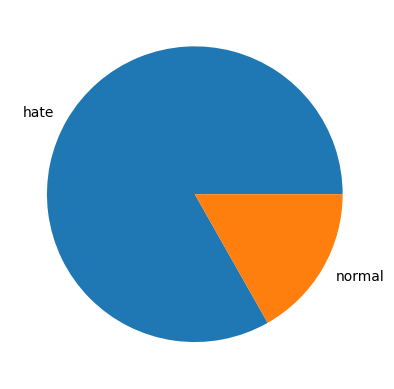

In [15]:
plt.pie(df["class"].value_counts().values, labels = le.inverse_transform(df["class"].value_counts().keys()))
plt.show()

In [16]:
hate_count, normal_count = df["class"].value_counts()

hate_class = df[df["class"] == 0]
normal_class = df[df["class"] == 1]

normal_class_upsample = normal_class.sample(hate_count, replace = True)

In [17]:
balanced_dataset = pd.concat([hate_class, normal_class_upsample])

In [18]:
balanced_dataset

,tweet,class
1,rt boy dat cold tyga dwn bad cuffin dat hoe st...,0
2,rt dawg rt you fuck bitch start cry you confus...,0
3,rt look like tranny,0
4,rt the shit hear true faker bitch told ya,0
5,the shit blow me claim faithful somebody fucki...,0
...,...,...
6037,worst terrorist republican teabaggers,1
5545,im trash ur trash baes,1
7675,almost half north american bird specie threate...,1
3800,you remember it funny coloured paper,1


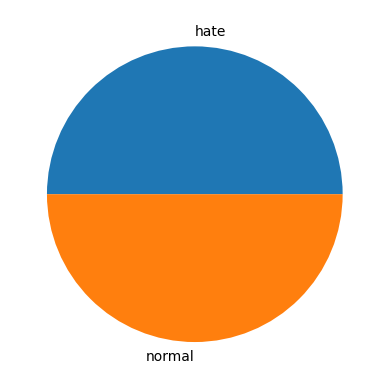

In [19]:
plt.pie(balanced_dataset["class"].value_counts().values, labels = le.inverse_transform(balanced_dataset["class"].value_counts().keys()))
plt.show()

In [20]:
balanced_dataset.shape

(41240, 2)

In [52]:
X_train, X_test, y_train, y_test = train_test_split(df["tweet"], df["class"], test_size = 0.2, random_state = 42, stratify = df["class"])
X_train.shape, X_test.shape

((19826,), (4957,))

In [53]:
y_train = np.array(y_train).reshape((-1,1))
y_test = np.array(y_test).reshape((-1,1))

In [54]:
max_words = 100
max_len = 50

token = Tokenizer(num_words=max_words, lower=True, split=' ')

token.fit_on_texts(X_train)

Training_seq = token.texts_to_sequences(X_train)

Training_pad = pad_sequences(Training_seq,
                             maxlen=50)

Testing_seq = token.texts_to_sequences(X_test)
Testing_pad = pad_sequences(Testing_seq,
                            maxlen=50)


In [80]:
import pickle
pickle.dump(token, open("token1.pkl", "wb"))

In [55]:
model = keras.models.Sequential([
    layers.Embedding(max_words, 32, input_length=max_len),
    layers.Bidirectional(layers.LSTM(16)),
    layers.Dropout(0.3),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

In [56]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'],
              run_eagerly = True)

In [57]:
stop_early = EarlyStopping(patience=3,
                   monitor = 'val_accuracy',
                   restore_best_weights = True)

change_learning_rate = ReduceLROnPlateau(patience = 2,
                       monitor = 'val_loss',
                       factor = 0.5,
                       verbose = 0)

callbacks = [stop_early, change_learning_rate]

In [58]:
history = model.fit(Training_pad, y_train,
                    validation_data=(Testing_pad, y_test),
                    epochs=5,
                    verbose=1,
                    batch_size=32,
                    callbacks=callbacks)

Epoch 1/5
620/620 [==============================] - 263s 424ms/step - loss: 0.2184 - accuracy: 0.9006 - val_loss: 0.2393 - val_accuracy: 0.8519 - lr: 0.0010
Epoch 2/5
620/620 [==============================] - 261s 422ms/step - loss: 0.1826 - accuracy: 0.9105 - val_loss: 0.1675 - val_accuracy: 0.9183 - lr: 0.0010
Epoch 3/5
620/620 [==============================] - 271s 436ms/step - loss: 0.1793 - accuracy: 0.9127 - val_loss: 0.1908 - val_accuracy: 0.9175 - lr: 0.0010
Epoch 4/5
620/620 [==============================] - 260s 419ms/step - loss: 0.1793 - accuracy: 0.9140 - val_loss: 0.1671 - val_accuracy: 0.9187 - lr: 0.0010
Epoch 5/5
620/620 [==============================] - 242s 391ms/step - loss: 0.1766 - accuracy: 0.9159 - val_loss: 0.1646 - val_accuracy: 0.9199 - lr: 0.0010


In [59]:
model.save("LSTM_model2.h5")

In [50]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

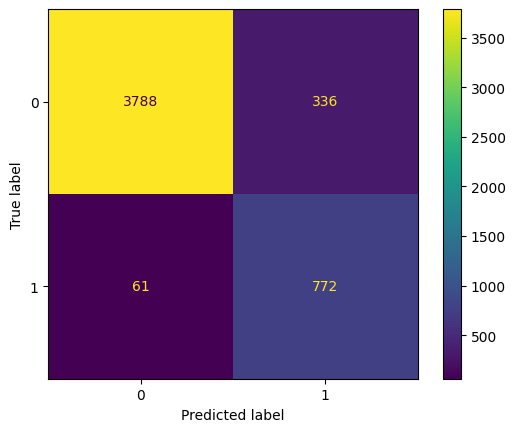

In [62]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
plt.show()